<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Starter**

In this notebook we will learn how to use [RAFT](https://arxiv.org/pdf/2003.12039.pdf) or Recurrent All-Pairs Field Transforms for Optical Flow

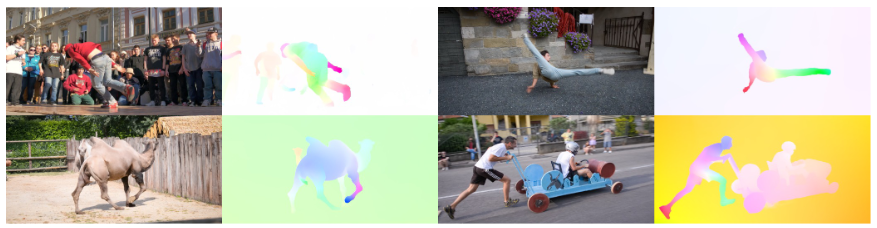

## **RAFT Models**

RAFT has several pretrained models:
 - raft-chairs - trained on FlyingChairs
 - raft-things - trained on FlyingChairs + FlyingThings
 - raft-sintel - trained on FlyingChairs + FlyingThings + Sintel + KITTI
 - raft-kitti - raft-sintel finetuned on only KITTI
 - raft-small - trained on FlyingChairs + FlyingThings

Clone the repo and import libraries

In [6]:
!git clone https://github.com/princeton-vl/RAFT.git

fatal: destination path 'RAFT' already exists and is not an empty directory.


In [7]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

Add RAFT core to path

In [8]:
sys.path.append('RAFT/core')

Get demo frames

In [10]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread(os.path.join(demo_path, 'frame_0020.png'))
frame2 = cv2.imread(os.path.join(demo_path, 'frame_0021.png'))
frame3 = cv2.imread(os.path.join(demo_path, 'frame_0023.png'))

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
frame3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB)

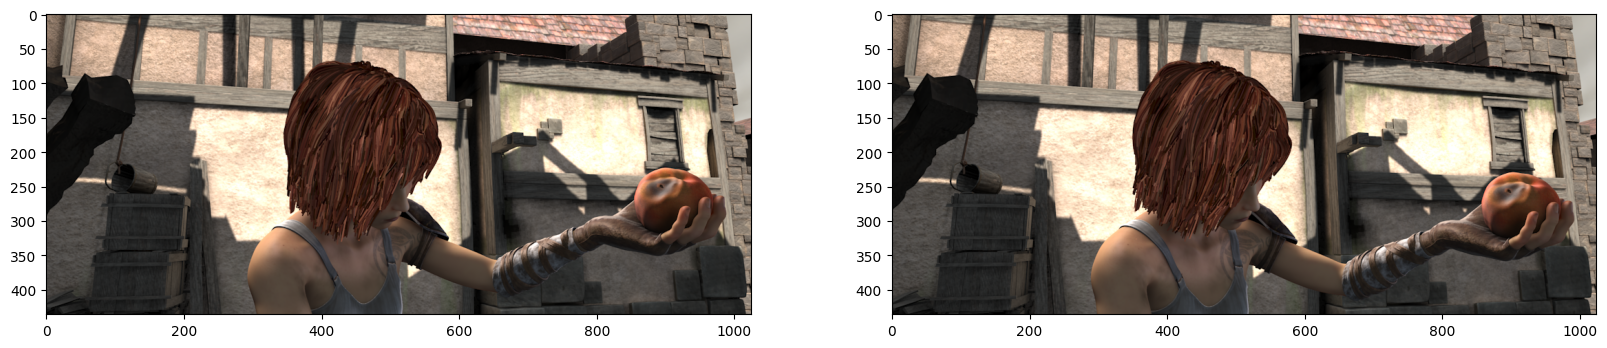

In [11]:
_, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].imshow(frame1)
ax[1].imshow(frame2);

## Download models

In [12]:
%cd RAFT
!./download_models.sh
# !python demo.py --model=models/raft-things.pth --path=demo-frames
%cd ..

/content/RAFT
--2023-09-19 13:01:03--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  42.3MB/s    in 1.8s    

2023-09-19 13:01:07 (42.3 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   
/content


### Helper functions

In [13]:
from collections import OrderedDict
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder



def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)



          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1,2,0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
  def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration

### Load Model

In [14]:
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

### Predict Optical Flow

In [15]:
flow_low, flow_up = inference(model, frame1, frame2, device='cuda')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
flow_low.shape, flow_up.shape

(torch.Size([1, 2, 55, 128]), torch.Size([1, 2, 440, 1024]))

### Display Results

In [17]:
flow_low_viz = get_viz(flow_low)
flow_up_viz = get_viz(flow_up)

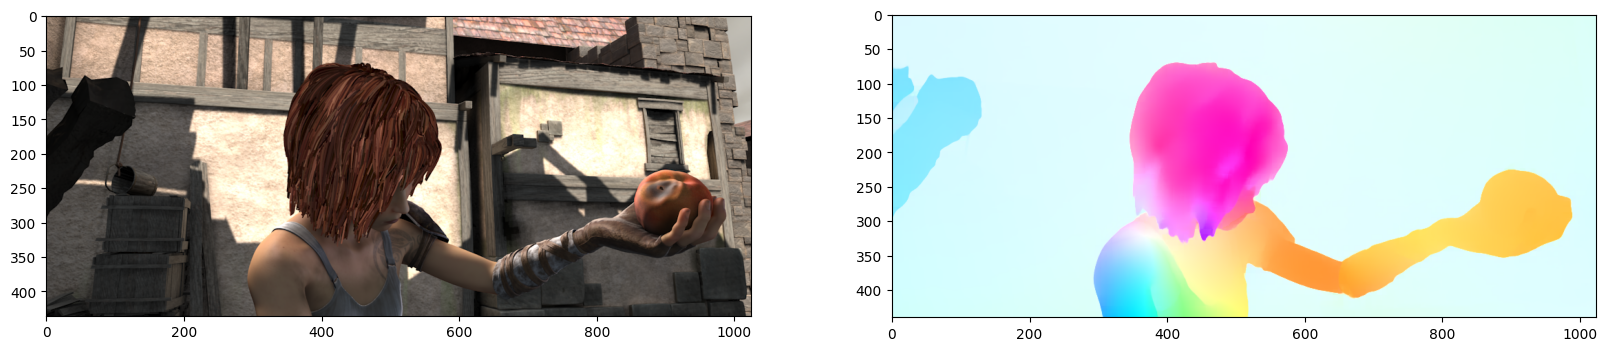

In [18]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(frame1)
ax1.imshow(flow_up_viz)
plt.show()

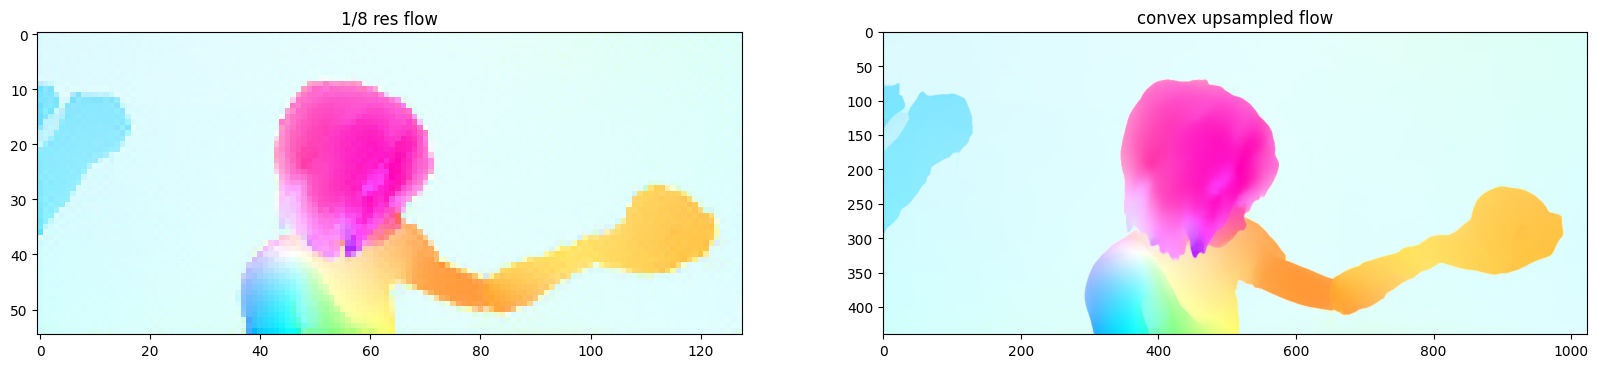

In [19]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(flow_low_viz)
ax0.set_title('1/8 res flow')
ax1.imshow(flow_up_viz)
ax1.set_title('convex upsampled flow');

In [20]:
flow_iters = inference(model, frame1, frame2, device='cuda', iters=20, test_mode=False)

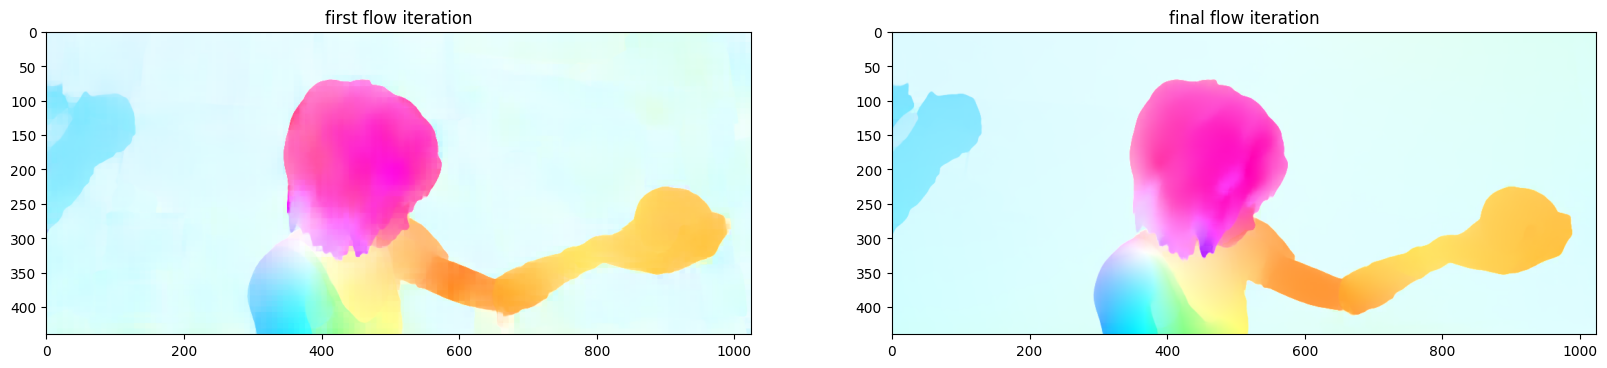

In [21]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

## **Estimate Flow with a Warm Start**

In [28]:
flow_lo_cold, flow_up_cold = inference(model, frame2, frame3, device='cuda', iters=20, test_mode=True)
flow_lo_warm, flow_up_warm = inference(model, frame2, frame3, device='cuda', flow_init=flow_lo_cold, iters=20, test_mode=True)

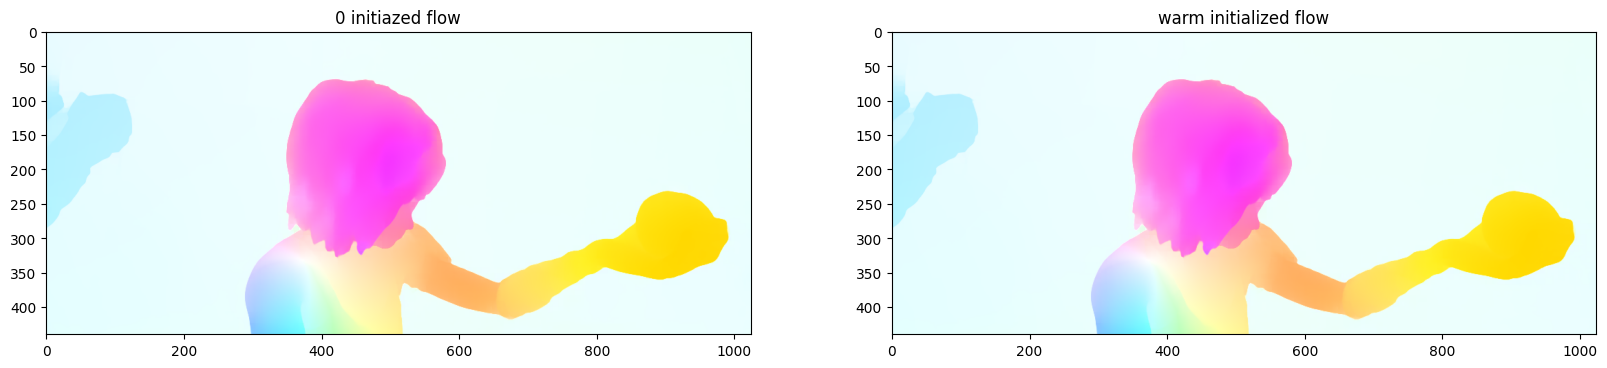

In [29]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_up_cold))
ax0.set_title('0 initiazed flow')
ax1.imshow(get_viz(flow_up_warm))
ax1.set_title('warm initialized flow');

## Try an example on Kitti

We can either use the KITTI website to download, or select a video sequence from the MOT challenge.

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_29_drive_0071/2011_09_29_drive_0071_sync.zip
!jar xf /content/2011_09_29_drive_0071_sync.zip

In [32]:
# !wget https://motchallenge.net/sequenceVideos/KITTI-16-raw.webm

--2023-09-19 13:20:15--  https://motchallenge.net/sequenceVideos/KITTI-16-raw.webm
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914595 (893K) [video/webm]
Saving to: ‘KITTI-16-raw.webm’

KITTI-16-raw.webm   100%[===================>] 893.16K  1.23MB/s    in 0.7s    

2023-09-19 13:20:16 (1.23 MB/s) - ‘KITTI-16-raw.webm’ saved [914595/914595]



## **Compute Flow on a video**

In [33]:
# cap = cv2.VideoCapture("KITTI-16-raw.webm")

# if (cap.isOpened() == False):
#     print("Error opening video file")

# fps = cap.get(cv2.CAP_PROP_FPS)
# raw_frames = []
# flows = []
# flow_lo = None
# i = 0
# while(cap.isOpened()):

#     # read each video frame
#     ret, frame = cap.read()

#     if ret == True:

#         # save to list
#         raw_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

#         # compute flow
#         flow_lo, flow_up = inference(model, frame2, frame3, device='cuda', flow_init=flow_lo, iters=20, test_mode=True)

#         flows.append(flow_up)

#         # increment counter
#         i += 1

#     # Break if nothing is returned
#     else:
#         break

# # clean up
# cap.release()
# cv2.destroyAllWindows()
# del cap

## **Flow example on a pair of frames**

Let's see how well RAFT does on a single pair of frames from the KITTI driving scene

In [39]:
from glob import glob

left_image_paths = sorted(glob('/content/2011_09_29/2011_09_29_drive_0071_sync/image_02/data/*.png'))
frames = [cv2.imread(path) for path in left_image_paths]

In [61]:
idx = 75
frame1 = frames[idx]
frame2 = frames[idx + 1]
frame3 = frames[idx + 2]

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
frame3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB)

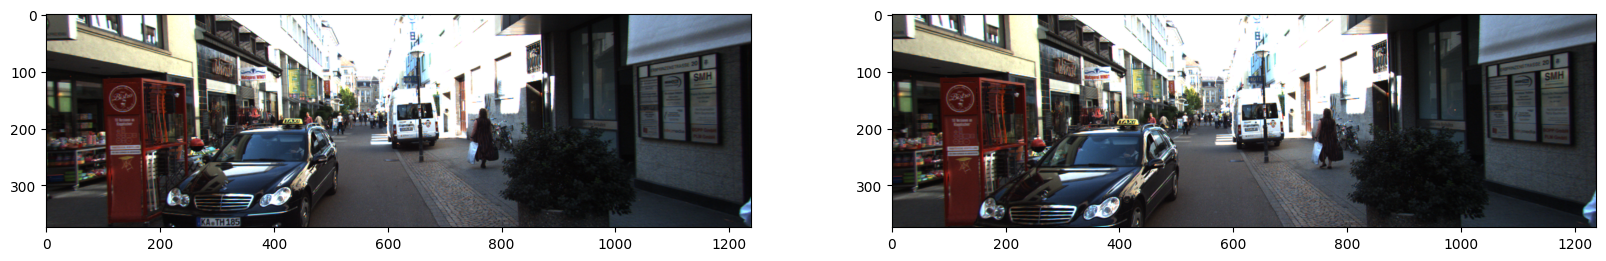

In [62]:
_, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].imshow(frame1)
ax[1].imshow(frame2);

In [63]:
## OPTIONAL (use KITTI only model)
# del model
# model = load_model("RAFT/models/raft-kitti.pth", args=Args())
flow_iters = inference(model, frame1, frame2, device='cuda', pad_mode='kitti', iters=20, test_mode=False)

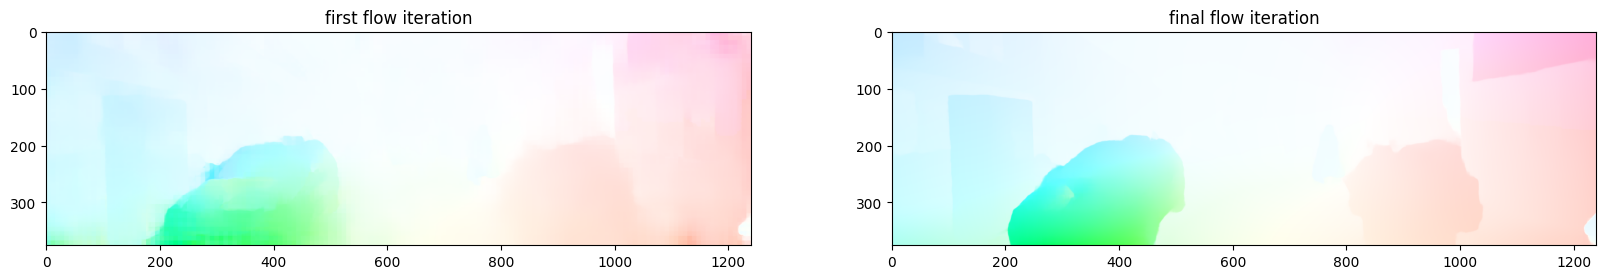

In [64]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

## **Perform warm start flow prediction**

In [67]:
flow_lo, flow_up = inference(model, frame1, frame2, device='cuda', pad_mode='kitti', iters=20, test_mode=True)
flow_lo_cold, flow_up_cold = inference(model, frame2, frame3, device='cuda', pad_mode='kitti', flow_init=None, iters=20, test_mode=True)
flow_lo_warm, flow_up_warm = inference(model, frame2, frame3, device='cuda', pad_mode='kitti', flow_init=flow_lo, iters=20, test_mode=True)

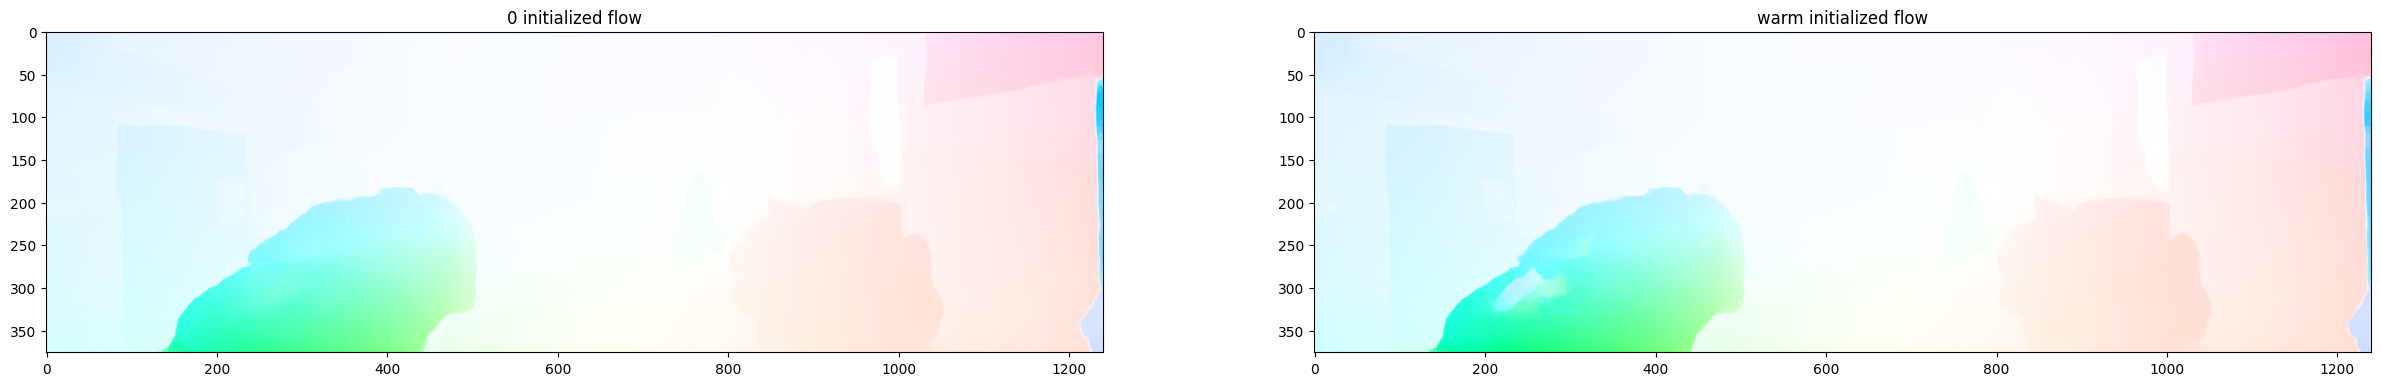

In [70]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(30,10))

ax0.imshow(get_viz(flow_up_cold))
ax0.set_title('0 initialized flow')
ax1.imshow(get_viz(flow_up_warm))
ax1.set_title('warm initialized flow');

In [ ]:
1